In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import pandas as pd
pd.set_option('display.max_rows', 270)

In [2]:
%matplotlib inline 
import json
import pyodbc
import numpy as np
import pandas as pd
import re
from scipy.stats import chi2, mstats
from anomaly_detection import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
# import plotly.plotly as py
# import plotly.tools as tls

pd.set_option('display.memory_usage', 'deep')
sns.set_palette('deep')

In [3]:
print("Last executed at:", pd.Timestamp.now(), "UTC")

Last executed at: 2019-09-11 07:36:55.190241 UTC


In [4]:
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=gsetitan.amer.dell.com;'
    r'DATABASE=GP_ML_DEV;'
    r'uid=domino_prod;'
    r'pwd=DontDeleteMe123!'
    )

query = \
"""
SELECT start_time_utc, keywords, lob_desc
    FROM [GP_ML].[dbo].[GP_APP_LOGS_PARSED]
    WHERE _insert_time >= CAST('2018-08-01' AS DATETIME)
"""

%time raw_logs = pd.read_sql(query, conn)
print()
raw_logs.info()
dd = raw_logs.columns
for col in dd:
    print (col)

CPU times: user 11 s, sys: 1.72 s, total: 12.7 s
Wall time: 12.7 s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054274 entries, 0 to 4054273
Data columns (total 3 columns):
start_time_utc    object
keywords          object
lob_desc          object
dtypes: object(3)
memory usage: 856.4 MB
start_time_utc
keywords
lob_desc


In [5]:
lob = pd.read_excel('LOB-ProductType-Mapping.xlsx')
lob_ls = lob.loc[lob['PROD_TYPE_DESC']=='Client Solutions PBU','LOB_DESC'].tolist()
raw_logs = raw_logs.loc[raw_logs['lob_desc'].isin(lob_ls),['start_time_utc','keywords']]
raw_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3301942 entries, 1 to 4054273
Data columns (total 2 columns):
start_time_utc    object
keywords          object
dtypes: object(2)
memory usage: 500.9 MB


In [6]:
raw_logs_I= transform_row(data=raw_logs,index='start_time_utc',col_to_split='keywords')

In [7]:
d = pd.DataFrame(raw_logs_I['keywords'].value_counts())
keys = d[d['keywords'] > 50].index.tolist()
raw_logs_II = raw_logs_I.loc[raw_logs_I['keywords'].isin(keys)]

In [8]:
global anomaly_variate
anomaly_variate = 'keywords'

# Cumulative Distribution Fraction Metrics

In [9]:
logs = historical_data(raw_logs_II, 'start_time_utc', lookback_window=pd.Timedelta(8,"M"))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9026890 entries, 2019-03-29 16:53:14+00:00 to 2019-08-07 07:21:23+00:00
Data columns (total 3 columns):
start_time_utc    datetime64[ns, UTC]
keywords          object
dummy             int64
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 742.5 MB
None


In [10]:
# recode less frequent values as "MISC" and clean text in mapped variable
df = cleanAndMap(logs, anomaly_variate, "_mapped")

* df = replace_value(df, frequency=50, colname =anomaly_variate+'_mapped', into='misc_keywords')
* df = df[df['keywords_mapped']!='misc_keywords']

# Monday-Monday, Tuesday-Tuesday, etc.

In [11]:
counts = category_counts_by_day(df, anomaly_variate + '_mapped').dropna(how='all')
frac = counts_to_fraction(counts).drop('total', axis=1)

## Variance Inflation Factor

* _ = vif_visual( counts.loc )
* _ = corr_plot( counts )

/opt/microsoft/mlserver/9.3.0/runtime/python/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


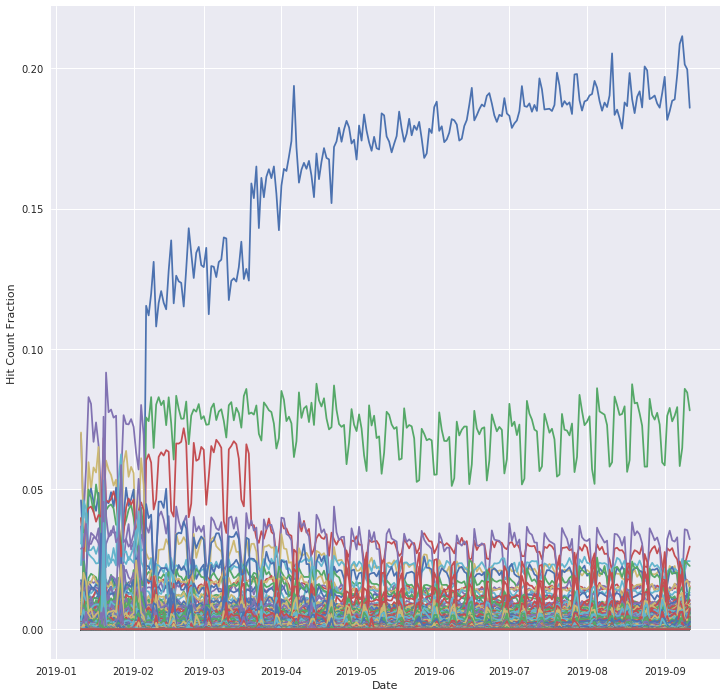

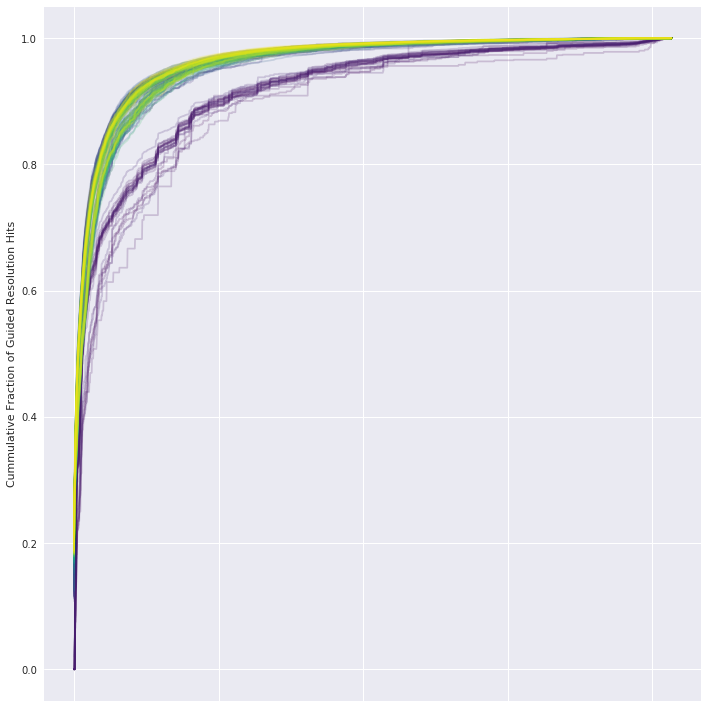

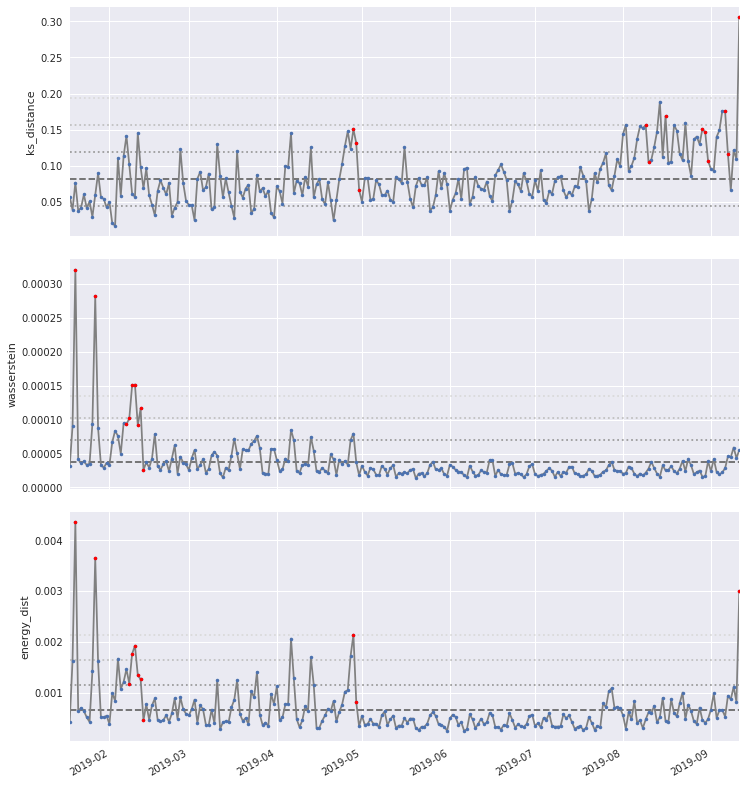

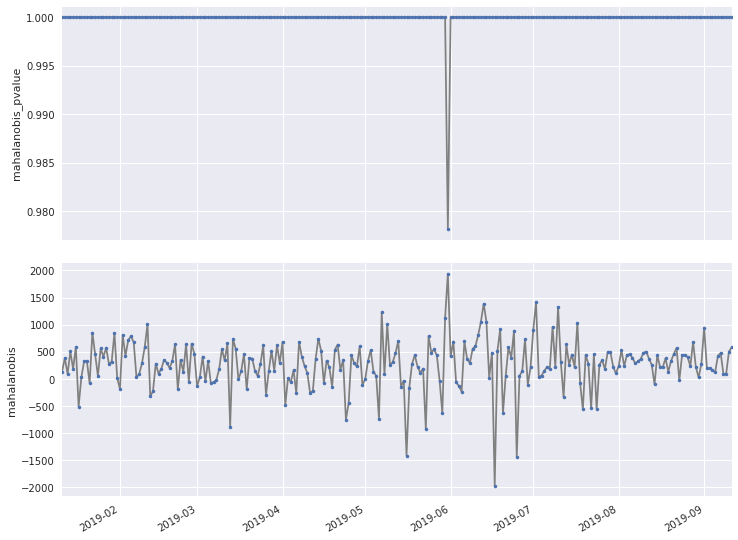

In [12]:
daily_metrics = distance_metrics(frac, pd.Timedelta(7, "D"))

for m in daily_metrics.columns:
    daily_metrics[m + "_anomaly"] = find_anomalies(daily_metrics[m])

mahal = counts.copy()
sub_cols = [col for col in counts.columns if col not in ['MISC','total']]
mahal['mahalanobis'] = mahalanobis(mahal[sub_cols], mahal[sub_cols])
mahal['mahalanobis_pvalue'] = 1 - chi2.cdf(mahal['mahalanobis'], len(mahal.columns)-1)
mahal_outlier_index = show_outliers(mahal, 'mahalanobis').index
mahal['mahalanobis_anomaly'] = False
mahal.loc[mahal_outlier_index, 'mahalanobis_anomaly'] = True

# _ = plot_counts( counts )
_ = plot_fractions( frac )
_ = plot_cdf( frac )
_ = control_charting( daily_metrics, "results/KeywordsPart-I/daily_proportionalVariate_control_charts.png" )
daily_metrics = daily_metrics.merge(mahal[['mahalanobis','mahalanobis_anomaly']], on='date_')
_ = mah_control_chart(mahal, mahal_outlier_index, "results/KeywordsPart-I/daily_multiVariate_control_charts.png")

# Week over Week

/opt/microsoft/mlserver/9.3.0/runtime/python/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


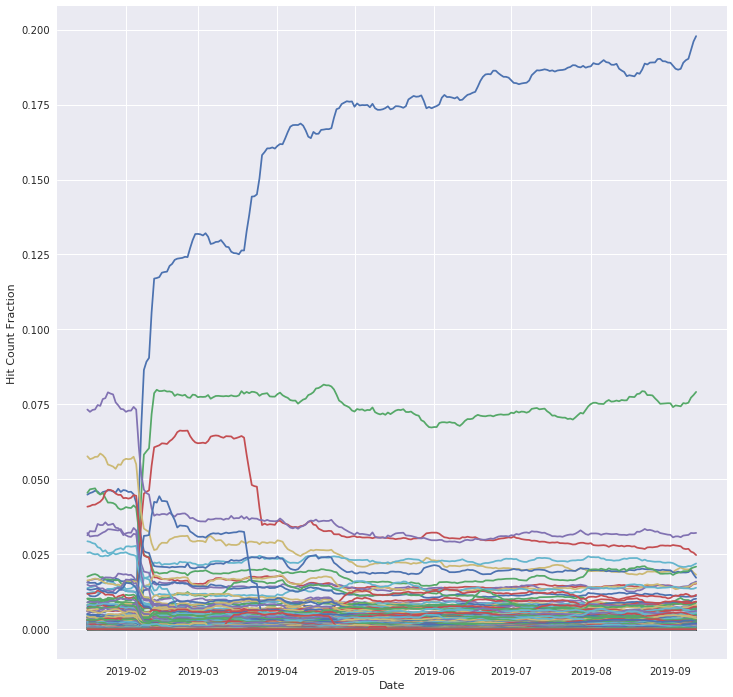

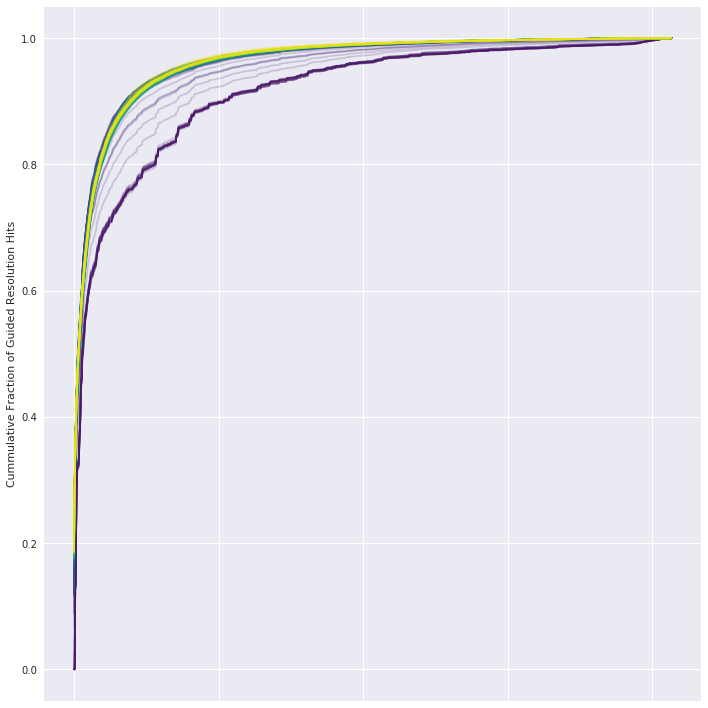

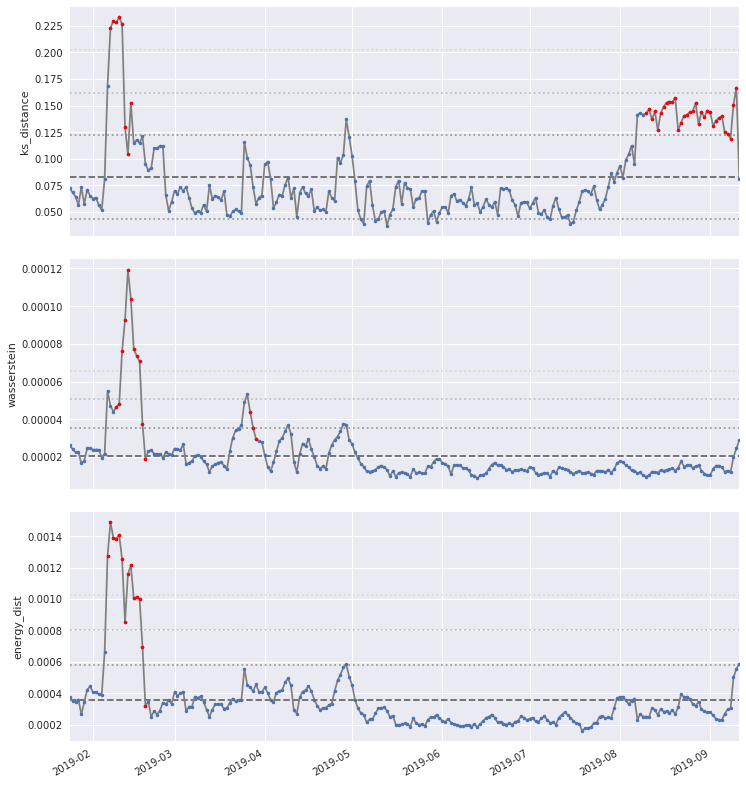

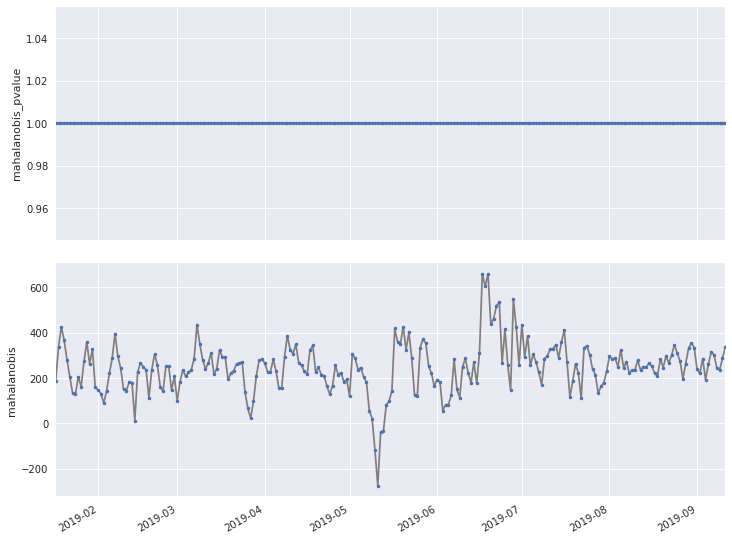

In [ ]:
# counts = category_counts_by_day(df,'hard_solutions_0_pred_mapped').rolling(7).sum().dropna(how='all')
counts = category_counts_by_day(df,anomaly_variate +'_mapped').rolling(7).sum().dropna(how='all')
frac = counts_to_fraction(counts).drop('total', axis=1)
weekly_metrics = distance_metrics(frac, pd.Timedelta(7, "D"))

for m in weekly_metrics.columns:
    weekly_metrics[m+"_anomaly"] = find_anomalies(weekly_metrics[m])

mahal = counts.copy()
sub_cols = [col for col in counts.columns if col not in ['MISC','total']]
mahal['mahalanobis'] = mahalanobis(mahal[sub_cols], mahal[sub_cols])
mahal['mahalanobis_pvalue'] = 1 - chi2.cdf(mahal['mahalanobis'], len(mahal.columns)-1)
mahal_outlier_index = show_outliers(mahal, 'mahalanobis').index
mahal['mahalanobis_anomaly'] = False
mahal.loc[mahal_outlier_index, 'mahalanobis_anomaly'] = True

# _ = plot_counts( counts )
_ = plot_fractions( frac )
_ = plot_cdf( frac )
_ = control_charting( weekly_metrics, "results/KeywordsPart-I/weekly_proportionalVariate_control_charts.png" )
weekly_metrics = weekly_metrics.merge(mahal[['mahalanobis','mahalanobis_anomaly']], on='date_')
# weekly_metrics = weekly_metrics[m_cols]
_ = mah_control_chart(mahal, mahal_outlier_index, "results/KeywordsPart-I/weekly_multiVariate_control_charts.png")

# Quarter over Quarter

In [ ]:
# counts = category_counts_by_day(df,'hard_solutions_0_pred_mapped').rolling(91).sum().dropna(how='all')
counts = category_counts_by_day(df,anomaly_variate+'_mapped').rolling(91).sum().dropna(how='all')
frac = counts_to_fraction(counts).drop('total', axis=1)
quarterly_metrics = distance_metrics(frac, pd.Timedelta(91, "D"))
for m in quarterly_metrics.columns:
    quarterly_metrics[m+"_anomaly"] = find_anomalies(quarterly_metrics[m])

mahal = counts.copy()
sub_cols = [col for col in counts.columns if col not in ['MISC','total']]
mahal['mahalanobis'] = mahalanobis(mahal[sub_cols], mahal[sub_cols])
mahal['mahalanobis_pvalue'] = 1 - chi2.cdf(mahal['mahalanobis'], len(mahal.columns)-1)
mahal_outlier_index = show_outliers(mahal, 'mahalanobis').index
mahal['mahalanobis_anomaly'] = False
mahal.loc[mahal_outlier_index, 'mahalanobis_anomaly'] = True

# _ = plot_counts( counts )
_ = plot_fractions( frac )
_ = plot_cdf( frac )
_ = control_charting( quarterly_metrics, "results/KeywordsPart-I/quarterly_proportionalVariate_control_charts.png" )
quarterly_metrics = quarterly_metrics.merge(mahal[['mahalanobis','mahalanobis_anomaly']], on='date_')
_ = mah_control_chart(mahal, mahal_outlier_index, "results/KeywordsPart-I/quarterly_multiVariate_control_charts.png")

/opt/microsoft/mlserver/9.3.0/runtime/python/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Diagnostics and Alerting

In [ ]:
daily_metrics.tail(1).T

In [ ]:
weekly_metrics.tail(1).T

In [ ]:
quarterly_metrics.tail(1).T

In [ ]:
dominostats = {}
for key in daily_metrics.iloc[-1].index:
    val = daily_metrics.iloc[-1][key]
    dominostats["daily_"+key] = int(val) if type(val) is np.bool_ else val
for key in weekly_metrics.iloc[-1].index:
    val = weekly_metrics.iloc[-1][key]
    dominostats["weekly_"+key] = int(val) if type(val) is np.bool_ else val
for key in quarterly_metrics.iloc[-1].index:
    val = quarterly_metrics.iloc[-1][key]
    dominostats["quarterly_"+key] = int(val) if type(val) is np.bool_ else val
with open('dominostats.json', 'w') as f:
    f.write(json.dumps(dominostats))

In [ ]:
daily_sum = dominostats['daily_energy_dist_anomaly'] + dominostats['daily_ks_distance_anomaly']\
   + dominostats['daily_mahalanobis_anomaly'] + dominostats['daily_wasserstein_anomaly']

weekly_sum = dominostats['weekly_energy_dist_anomaly'] + dominostats['weekly_ks_distance_anomaly']\
   + dominostats['weekly_mahalanobis_anomaly'] + dominostats['weekly_wasserstein_anomaly']

quarterly_sum = dominostats['quarterly_energy_dist_anomaly'] + dominostats['quarterly_ks_distance_anomaly']\
   + dominostats['quarterly_mahalanobis_anomaly'] + dominostats['quarterly_wasserstein_anomaly']

anomalies_detected = []

if max(daily_sum, weekly_sum, quarterly_sum) > 1:
    for key in dominostats.keys():
        if 'anomaly' in key and dominostats[key]:
            anomalies_detected.append(key[:-8])
    send_email_notification("Keywords-I-Frequency > 50", "KeywordsPart-I", *anomalies_detected)
else:
    print('No anomaly')
    send_email_notification("Keywords-I-Frequency > 50", "KeywordsPart-I")


anomalies_detected

In [ ]:
# anomalies_detected = []
# for key in dominostats.keys():
#     if 'anomaly' in key and dominostats[key]:
#         anomalies_detected.append(key[:-8])
# send_email_notification(*anomalies_detected)
# anomalies_detected